## Setup

In [95]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)



import tensorflow as tf
print(f'tensorflow version {tf.__version__}')

Azure ML SDK Version:  1.19.0
tensorflow version 2.4.0


## Connect to workspace

In [96]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

HTN	eastus	HTN


## Init Experiment

In [97]:
experiment_name = 'giftbox'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

## Create compute target if not exists

In [98]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target: cpu-cluster


## Download the training dataset

In [18]:
from azureml.core import Dataset
import os
import zipfile
import requests

data_folder = os.path.join(os.getcwd(), 'data')

data_url = 'https://codeload.github.com/yi-fan-song/HTN2021-dataset/zip/main'
r = requests.get(data_url, allow_redirects=True)

with open('data.zip', 'wb') as writingfile:
    writingfile.write(r.content)

with zipfile.ZipFile(os.path.join(os.getcwd(), 'data.zip'), 'r') as zip_ref:
    zip_ref.extractall(data_folder)

data_folder = os.path.join(data_folder, 'HTN2021-dataset-main')

Found 363 images belonging to 10 classes.
[[[194. 188. 172.]
  [194. 188. 172.]
  [194. 188. 172.]
  ...
  [198. 196. 175.]
  [198. 196. 175.]
  [198. 196. 175.]]

 [[196. 190. 174.]
  [196. 190. 174.]
  [196. 190. 174.]
  ...
  [200. 197. 178.]
  [200. 197. 178.]
  [200. 197. 178.]]

 [[196. 190. 176.]
  [196. 190. 176.]
  [196. 190. 176.]
  ...
  [201. 198. 181.]
  [201. 198. 181.]
  [201. 198. 181.]]

 ...

 [[116. 112. 103.]
  [116. 112. 103.]
  [116. 112. 103.]
  ...
  [116. 109. 101.]
  [116. 109. 101.]
  [110. 103.  95.]]

 [[115. 111. 102.]
  [115. 111. 102.]
  [115. 111. 102.]
  ...
  [113. 106.  98.]
  [114. 107.  99.]
  [113. 106.  98.]]

 [[114. 110. 101.]
  [114. 110. 101.]
  [114. 110. 101.]
  ...
  [112. 105.  97.]
  [114. 107.  99.]
  [114. 107.  99.]]]
1.0


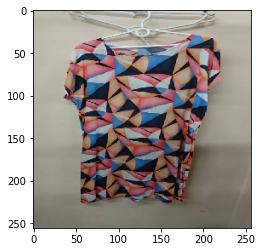

In [99]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

test_datagen = ImageDataGenerator()
test_folder = os.path.join(data_folder, 'test')

labels = os.listdir(os.path.join(data_folder, 'test'))

test_gen = test_datagen.flow_from_directory(test_folder, target_size=(256,256), class_mode='sparse',
                                            batch_size=4, shuffle=False, subset=None, classes=labels)

for x,y in test_gen:
    plt.imshow(x[3] / 255, data= {})
    print(x[3])
    print(y[3])
    break

In [116]:
labels

['bicycle',
 'dress',
 'longsleeve',
 'outwear',
 'pants',
 'shirt',
 'shoes',
 'shorts',
 'skirt',
 't-shirt']

## Training script
This is basically black magic, I don't really know what's going on

In [106]:
%%writefile ./train.py

import argparse
import os
import numpy as np
import glob
import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils

from azureml.core import Run

import zipfile
import requests

def image_process(x):
    '''
    Create a custom layer that converts the original image from 
    RGB to HSV and grayscale and concatenates the results
    forming in input of size 100 x 100 x 4 
    '''
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez

def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(image_process)(img_input)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(368, activation='relu', name='fcl2')(x)
    x = Dense(128, activation='relu', name='fcl3')(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    return Model(inputs=img_input, outputs=out)

    

def resize_image(image, target_size):
    return cv2.resize(image, dsize=target_size, interpolation=cv2.INTER_CUBIC)

def load_data(path):
    x = np.zeros((0, 256, 256, 3))
    y = np.zeros((0))
    for folder in os.listdir(path):
        for filename in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, filename))

            x = np.concatenate((x, [resize_image(img, (256, 256))]), axis= 0)
            y = np.append(y, folder)
    return x, y
    


data_folder = os.path.join(os.getcwd(), 'data')

data_url = 'https://codeload.github.com/yi-fan-song/HTN2021-dataset/zip/main'
r = requests.get(data_url, allow_redirects=True)

with open('data.zip', 'wb') as writingfile:
    writingfile.write(r.content)

with zipfile.ZipFile(os.path.join(os.getcwd(), 'data.zip'), 'r') as zip_ref:
    zip_ref.extractall(data_folder)

data_folder = os.path.join(data_folder, 'HTN2021-dataset-main')
os.makedirs(data_folder, exist_ok=True)

train_folder = os.path.join(data_folder, 'train')
test_folder = os.path.join(data_folder, 'test')
validation_folder = os.path.join(data_folder, 'validation')
print('Data folder:', data_folder)

image_size = (256, 256)
input_shape = (256, 256, 3)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
# X_train, y_train = load_data(train_folder)
X_test, y_test = load_data(test_folder)

next(os.walk(train_folder))[1]
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

labels = os.listdir(train_folder)
model = network(input_shape, len(next(os.walk(train_folder))[1]))

optimizer = Adam()
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0,
        rotation_range=5,
        height_shift_range=0,
        zoom_range=0,
        horizontal_flip=True,
        fill_mode='nearest')
        
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0,
        rotation_range=5,
        height_shift_range=0,
        zoom_range=0,
        horizontal_flip=True,
        fill_mode='nearest')

train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                              batch_size=32, shuffle=True, subset=None, classes=labels)
validation_gen = validation_datagen.flow_from_directory(validation_folder, target_size=image_size, class_mode='sparse',
                                                   batch_size=32, shuffle=False, subset=None, classes=labels)
test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
                                            batch_size=32, shuffle=False, subset=None, classes=labels)

model.fit(x = train_gen, epochs = 15, steps_per_epoch = (train_gen.n // 32) + 1,
          validation_data = validation_gen, validation_steps=(validation_gen.n // 32) + 1)

print('Predict the test set')
y_hat = model.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(0.1))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
model.save('outputs/giftboxcnn.model')

# joblib.dump(value=model, filename='outputs/giftboxcnn.pkl')

Overwriting ./train.py


In [107]:
import shutil
shutil.copy('train.py', './scripts/train.py')

'./scripts/train.py'

In [112]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('giftbox')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults', 'tensorflow', 'Pillow', 'SciPy'], conda_packages = ['opencv'])

env.python.conda_dependencies = cd

# Register environment to re-use later
env.register(workspace = ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20200821.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "giftbox",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"
    

In [113]:
from azureml.core import ScriptRunConfig


src = ScriptRunConfig(source_directory='./scripts',
                      script='train.py', 
                      compute_target=compute_target,
                      environment=env)

In [114]:
run = exp.submit(config=src)
run

Experiment,Id,Type,Status,Details Page,Docs Page
giftbox,giftbox_1610870339_33b9f2e6,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [115]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…